In [4]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os 
import torch 
import torch.nn as nn
import torch.optim as optim


from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from vnstock import Vnstock
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
#Lấy mốc thời gia bắt đầu lấy dữ liệu do người dùng nhập vào
start = input("Nhập ngày bắt đầu lấy dữ liệu (yyyy-mm-dd): ")

#Tự động lấy ngày hiện tại làm ngày kết thúc
end = dt.datetime.now().strftime('%Y-%m-%d')

In [7]:
#Nhập mã cổ phiếu cần lấy dữ liệu
stock_symbol = input("Nhập mã cổ phiếu (ví dụ: VIC, VHM, VCB,...): ")

#Lấy dữ liệu cổ phiếu từ vnstock
try :
    stock = Vnstock().stock(symbol=stock_symbol, source='VCI')
    stock_data = stock.quote.history(start=start, end=end)
except ValueError as e:
    print(f"{e}: Vui lòng kiểm tra lại mã cổ phiếu hoặc ngày tháng.")
    exit()

#Đẩy dữ liệu vào DataFrame và in dữ liệu 5 dòng đầu và cuối
df = pd.DataFrame(stock_data)
print(df.head())
print(df.tail())

        time    open    high     low   close  volume
0 2020-01-02  102.13  102.22  101.33  102.22  440280
1 2020-01-03  102.22  102.49  101.60  102.49  248940
2 2020-01-06  102.22  102.22  101.69  101.78  301910
3 2020-01-07  101.78  102.22  101.60  101.96  183910
4 2020-01-08  101.78  101.96  100.98  101.60  468910
           time   open   high    low  close   volume
1446 2025-10-20  200.0  204.5  190.0  194.9  5671000
1447 2025-10-21  202.0  204.9  193.7  203.4  3700400
1448 2025-10-22  204.0  204.0  193.0  203.0  4196300
1449 2025-10-23  202.9  215.5  200.0  215.0  4761200
1450 2025-10-24  215.4  222.9  215.1  219.0  3412900


In [8]:
df['H-L'] = df['high'] - df['low']
df['O-C'] = df['open'] - df['close']

ma_20 = 20
ma_50 = 50
ma_200 = 200

df[f'SMA_{ma_20}'] = df['close'].rolling(window=ma_20).mean()
df[f'SMA_{ma_50}'] = df['close'].rolling(window=ma_50).mean()
df[f'SMA_{ma_200}'] = df['close'].rolling(window=ma_200).mean()

df[f'SD_{ma_50}'] = df['close'].rolling(window=ma_50).std()
df[f'SD_{ma_200}'] = df['close'].rolling(window=ma_200).std()

#RSI (Relative Strength Index)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df.dropna(inplace=True)
print(df.head())

          time   open   high    low  close   volume   H-L   O-C   SMA_20  \
199 2020-10-20  86.58  87.02  85.16  86.93   511250  1.86 -0.35  83.5435   
200 2020-10-21  86.93  87.02  85.96  86.49   172010  1.06  0.44  83.6680   
201 2020-10-22  86.22  88.98  86.05  88.98   621610  2.93 -2.76  83.9835   
202 2020-10-23  89.07  93.25  88.89  92.45  1761080  4.36 -3.38  84.4815   
203 2020-10-26  96.89  97.33  93.25  93.42   974720  4.08  3.47  85.0280   

      SMA_50   SMA_200     SD_50    SD_200        RSI  
199  81.8184  85.40185  2.791522  8.089648  78.397566  
200  81.9926  85.32320  2.806097  8.001299  72.688629  
201  82.2184  85.25565  2.905298  7.912174  75.662879  
202  82.5030  85.20900  3.188774  7.841445  85.522388  
203  82.8176  85.16630  3.467967  7.772722  95.322086  


In [9]:
#Đổi tên cột để dễ hiểu
df.rename(columns={'time': 'yyyy-mm-dd', 'open': 'Giá mở cửa', 'high': 'Giá trần', 'low': 'Giá sàn', 'close': 'Giá đóng cửa', 'volume': 'Khối lượng giao dịch'}, inplace=True)

# Chuyển cột ngày sang kiểu datetime
df["yyyy-mm-dd"] = pd.to_datetime(df["yyyy-mm-dd"], errors="coerce")

# Chuyển các cột số sang float
numeric_cols = ["Giá mở cửa", "Giá trần", "Giá sàn", "Giá đóng cửa","Khối lượng giao dịch", "H-L", "O-C", "SMA_20", "SMA_50", "SMA_200", "SD_50", "SD_200", "RSI"]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

print(df.head())
print(df.tail())

    yyyy-mm-dd  Giá mở cửa  Giá trần  Giá sàn  Giá đóng cửa  \
199 2020-10-20       86.58     87.02    85.16         86.93   
200 2020-10-21       86.93     87.02    85.96         86.49   
201 2020-10-22       86.22     88.98    86.05         88.98   
202 2020-10-23       89.07     93.25    88.89         92.45   
203 2020-10-26       96.89     97.33    93.25         93.42   

     Khối lượng giao dịch   H-L   O-C   SMA_20   SMA_50   SMA_200     SD_50  \
199                511250  1.86 -0.35  83.5435  81.8184  85.40185  2.791522   
200                172010  1.06  0.44  83.6680  81.9926  85.32320  2.806097   
201                621610  2.93 -2.76  83.9835  82.2184  85.25565  2.905298   
202               1761080  4.36 -3.38  84.4815  82.5030  85.20900  3.188774   
203                974720  4.08  3.47  85.0280  82.8176  85.16630  3.467967   

       SD_200        RSI  
199  8.089648  78.397566  
200  8.001299  72.688629  
201  7.912174  75.662879  
202  7.841445  85.522388  
203  7.7727

In [10]:
#Tạo thư mục để lưu trữ lịch sử truy xuất nếu chưa tồn tại
folder_name = "Lịch sử truy xuất"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
#Lưu dữ liệu vào file CSV
file_path = os.path.join(folder_name, f"Cổ_phiếu_{stock_symbol}.csv")
df.to_csv(file_path, index=False, encoding='utf-8-sig')

print(f"Đã lưu file tại: {file_path}")

Đã lưu file tại: Lịch sử truy xuất/Cổ_phiếu_VIC.csv


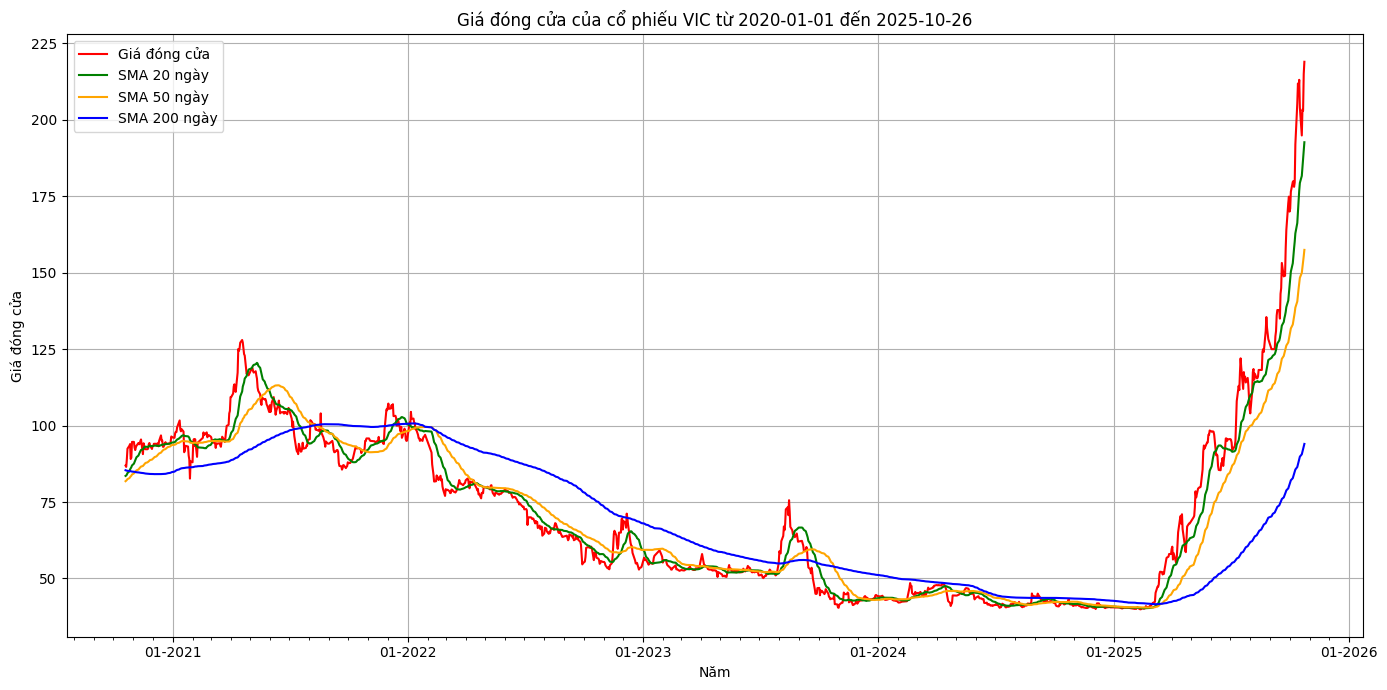

In [11]:
# Tạo đồ thị giá đóng cửa qua các năm và thêm đường trung bình động 20, 50 và 200 ngày
plt.figure(figsize=(14,7))
plt.plot(df['yyyy-mm-dd'], df['Giá đóng cửa'], label='Giá đóng cửa', color='red')
plt.plot(df['yyyy-mm-dd'], df[f'SMA_{ma_20}'], label=f'SMA {ma_20} ngày', color='green')
plt.plot(df['yyyy-mm-dd'], df[f'SMA_{ma_50}'], label=f'SMA {ma_50} ngày', color='orange')
plt.plot(df['yyyy-mm-dd'], df[f'SMA_{ma_200}'], label=f'SMA {ma_200} ngày', color='blue')
plt.title(f'Giá đóng cửa của cổ phiếu {stock_symbol} từ {start} đến {end}')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm tháng
years = YearLocator()   # Định vị các năm
yearsFmt = DateFormatter('%m-%Y')  # Định dạng hiển thị năm
months = MonthLocator()  # Định vị các tháng
monthsFmt = DateFormatter('%m')  # Định dạng hiển thị tháng

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)
# plt.gca().xaxis.set_minor_formatter(monthsFmt)

plt.tight_layout()
plt.grid()
plt.show()

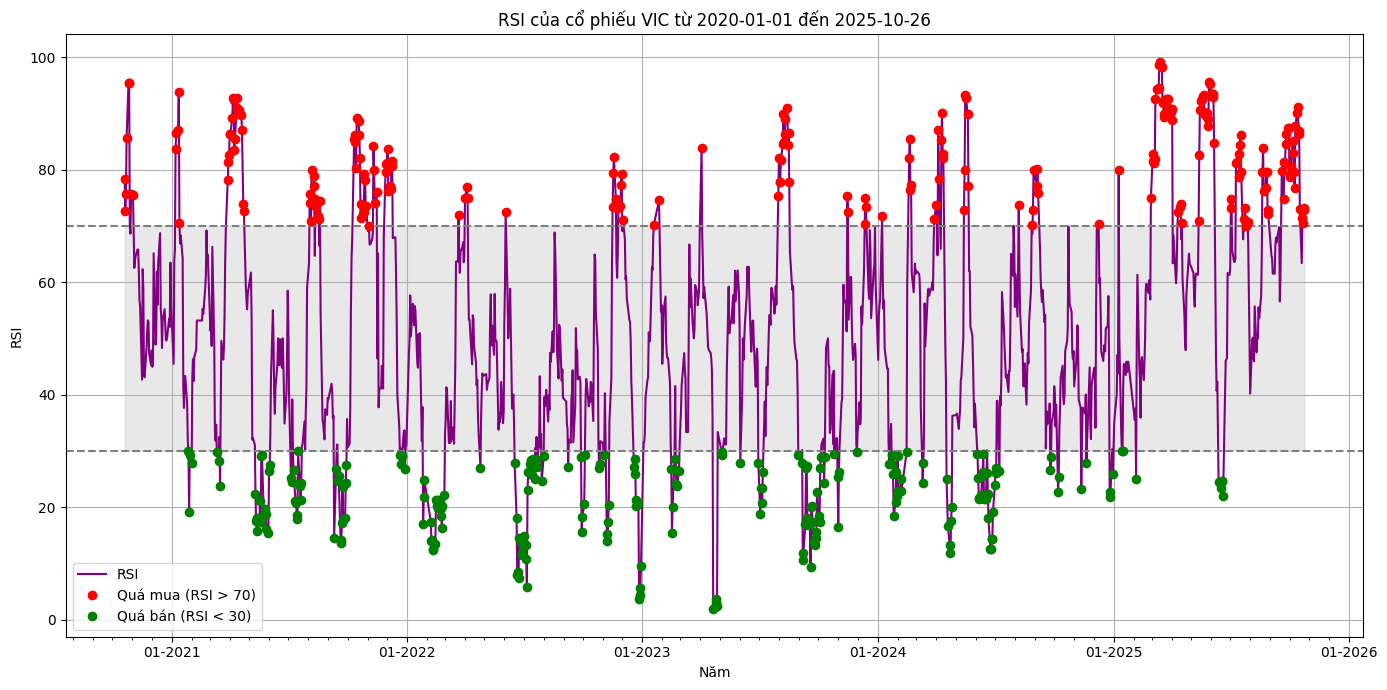

In [12]:
# Tạo thêm biểu đồ hiển thị RSI 
plt.figure(figsize=(14,7))
plt.plot(df['yyyy-mm-dd'], df['RSI'], label='RSI', color='purple')

# Vẽ các đường ngưỡng 70 và 30
plt.axhline(70, color='gray', linestyle='--')
plt.axhline(30, color='gray', linestyle='--')
# Tô màu vùng quá mua và quá bán
plt.fill_between(df['yyyy-mm-dd'], 30, 70, color='lightgray', alpha=0.5)

# Tôi muốn đường RSI vượt ngưỡng 70 là màu đỏ cơ, dưới 30 là màu xanh lá 
overbought = df['RSI'] > 70
oversold = df['RSI'] < 30
plt.plot(df['yyyy-mm-dd'][overbought], df['RSI'][overbought], 'ro', label='Quá mua (RSI > 70)')
plt.plot(df['yyyy-mm-dd'][oversold], df['RSI'][oversold], 'go', label='Quá bán (RSI < 30)')

# Thêm tiêu đề và nhãn trục
plt.title(f'RSI của cổ phiếu {stock_symbol} từ {start} đến {end}')
plt.xlabel('Năm')
plt.ylabel('RSI')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm tháng
years = YearLocator()   # Định vị các năm
yearsFmt = DateFormatter('%m-%Y')  # Định dạng hiển thị năm
months = MonthLocator()  # Định vị các tháng
monthsFmt = DateFormatter('%m')  # Định dạng hiển thị tháng
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)
# plt.gca().xaxis.set_minor_formatter(monthsFmt)
plt.tight_layout()
plt.grid()
plt.show()


In [42]:
# Tôi đang muốn build một model dự đoán giá cổ phiếu sử dụng LSTM với PyTorch
class PredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Chuẩn bị dữ liệu: Chọn các tính năng (features) và nhãn (labels) từ DataFrame của bạn. Chia dữ liệu thành tập huấn luyện và tập kiểm
# Tạo mô hình và định nghĩa tham số
model = PredictionModel(input_size, hidden_size, num_layers, output_size).to(device)

# Định nghĩa hàm mất mát và bộ tối ưu
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Chuẩn bị dữ liệu (ví dụ đơn giản)
# Giả sử bạn đã có dữ liệu giá cổ phiếu trong một mảng numpy
data = df['Giá đóng cửa'].values.astype(float)
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))
# Tạo các chuỗi thời gian cho LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
x_train, y_train = create_sequences(data, sequence_length)
# Chuyển đổi dữ liệu sang tensor
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# Lưu mô hình đã huấn luyện
model_path = os.path.join(folder_name, f'model_{stock_symbol}.pth')
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Dự đoán giá cổ phiếu
model.eval()
with torch.no_grad():
    y_train_pred = model(x_train)
# Chuyển đổi dự đoán về dạng ban đầu
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().numpy())
y_train = scaler.inverse_transform(y_train.cpu().numpy())
# Tính toán RMSE
rmse = np.sqrt(root_mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {rmse:.4f}')

# Vẽ đồ thị kết quả dự đoán
plt.figure(figsize=(14,7))
plt.plot(y_train, label='Giá thực tế', color='blue')
plt.plot(y_train_pred, label='Giá dự đoán', color='red')
plt.title(f'Dự đoán giá cổ phiếu {stock_symbol} bằng LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.grid()
plt.show()
    

In [43]:
# Tạo mô hình
model = PredictionModel(input_size = 1, hidden_size = 32, num_layers = 2, output_size = 1).to(device)

In [44]:
# Định nghĩa hàm mất mát và bộ tối ưu
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
# Chuẩn bị dữ liệu
# Giả sử bạn đã có dữ liệu giá cổ phiếu trong một mảng numpy
data = df['Giá đóng cửa'].values.astype(float)
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

In [53]:
# Tạo các chuỗi thời gian cho LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
x_train, y_train = create_sequences(data, seq_length)

In [47]:
#Chuyển đổi dữ liệu sang tensor
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)

In [48]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.9357
Epoch [20/100], Loss: 0.7725
Epoch [30/100], Loss: 0.3878
Epoch [40/100], Loss: 0.1266
Epoch [50/100], Loss: 0.1330
Epoch [60/100], Loss: 0.0910
Epoch [70/100], Loss: 0.0768
Epoch [80/100], Loss: 0.0576
Epoch [90/100], Loss: 0.0440
Epoch [100/100], Loss: 0.0332


In [49]:
# Dự đoán giá cổ phiếu
model.eval()
with torch.no_grad():
    y_train_pred = model(x_train)

In [50]:
# Chuyển đổi dự đoán về dạng ban đầu
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().numpy())
y_train = scaler.inverse_transform(y_train.cpu().numpy())

In [51]:
# Tính toán RMSE
rmse = np.sqrt(root_mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 0.4237


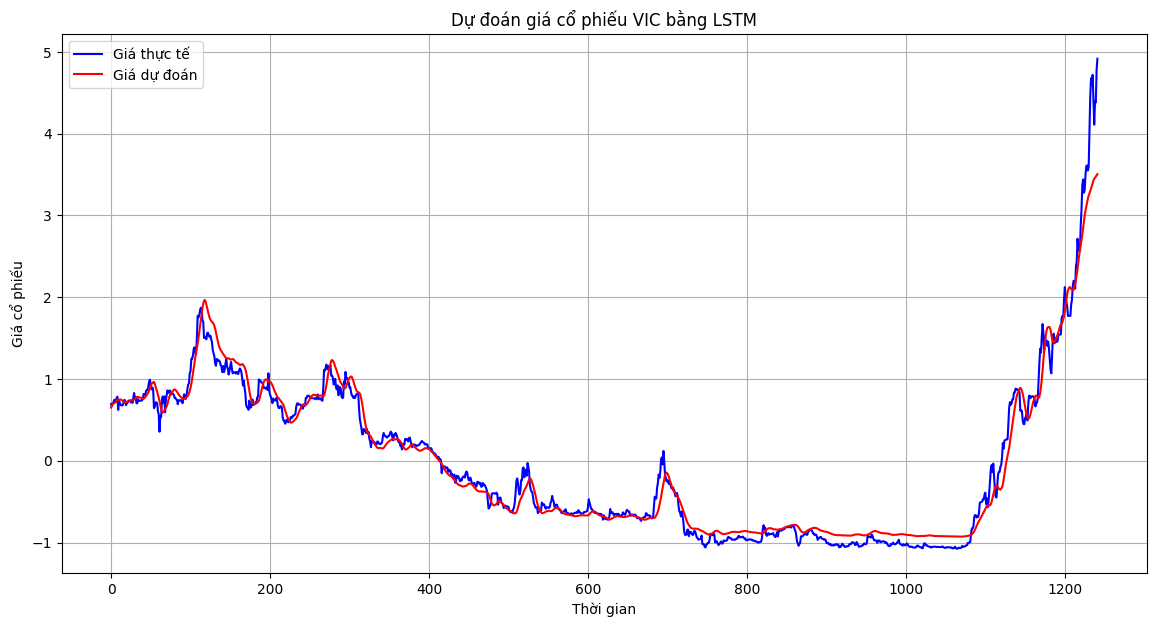

In [52]:
# Vẽ đồ thị kết quả dự đoán
plt.figure(figsize=(14,7))
plt.plot(y_train, label='Giá thực tế', color='blue')
plt.plot(y_train_pred, label='Giá dự đoán', color='red')
plt.title(f'Dự đoán giá cổ phiếu {stock_symbol} bằng LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.grid()
plt.show()
    